# Mitochondrial Gene Identification

This notebook integrates steps to identify mitochondrial genes in a new species using a reference species and analyze expression correlation.

In [7]:
import gffutils
import pandas as pd


## 1. Preprocess GTF to keep longest transcript

In [8]:
def keep_longest_transcripts(gtf_path, out_gtf, db_path=None):
    """Keep only the longest transcript for each gene in a GTF file."""
    db_path = db_path or gtf_path + '.db'
    db = gffutils.create_db(gtf_path, dbfn=db_path, force=True,
                            keep_order=True, disable_infer_genes=True,
                            disable_infer_transcripts=True)
    tx_lengths = []
    for tx in db.features_of_type('transcript', order_by='start'):
        exons = list(db.children(tx, featuretype='exon', order_by='start'))
        length = sum(e.end - e.start + 1 for e in exons)
        gene_id = tx.attributes['gene_id'][0]
        tx_lengths.append((tx.id, gene_id, length))
    df = pd.DataFrame(tx_lengths, columns=['transcript_id','gene_id','length'])
    longest_tx = df.sort_values('length').drop_duplicates('gene_id', keep='last')
    with open(out_gtf, "w") as out:
        for tx_id in longest_tx.transcript_id:
            for feature in db.children(tx_id, featuretype='exon', order_by='start', level=1):
                out.write(str(feature) + "\n")


Use the function for mouse and species X:

In [ ]:

keep_longest_transcripts('/home/gyang/HDD/0.Software_annos/gtf/GCF_032444005.1_aRanImi1.pri_genomic.gtf', '/home/gyang/HDD/0.Software_annos/BCP_utilities/resource/RI_longest.gtf')
keep_longest_transcripts('/home/gyang/HDD/0.Software_annos/gtf/CZI/mm10.ncbiRefSeq.gtf', '/home/gyang/HDD/0.Software_annos/BCP_utilities/resource/MG_longest.gtf')


## 2. Find reciprocal best BLAST hits

#### Here for mouse data we first delete small gtf contigs not shown in fasta

In [13]:
%%bash
# bash
filter_gtf_by_fa() {
  local fa="$1" gtf="$2" out_gtf="${3:-${gtf%.gtf}.filtered.gtf}"
  local seqs="__fa_seqs.$$" gtf_seqs="__gtf_seqs.$$" missing="missing_seqs.txt"

  if [[ -z "$fa" || -z "$gtf" ]]; then
    echo "Usage: filter_gtf_by_fa /path/to/genome.fa /path/to/input.gtf [out_filtered.gtf]"
    return 2
  fi

  # get fasta sequence names
  if command -v samtools >/dev/null 2>&1; then
    samtools faidx "$fa" || { echo "samtools faidx failed for $fa"; return 3; }
    cut -f1 "${fa}.fai" | sort -u > "$seqs"
  else
    if [[ "$fa" == *.gz ]]; then
      zcat "$fa" 2>/dev/null | grep -E '^>' | sed 's/^>//' | cut -d' ' -f1 | sort -u > "$seqs" || { echo "failed to read $fa"; return 4; }
    else
      grep -E '^>' "$fa" | sed 's/^>//' | cut -d' ' -f1 | sort -u > "$seqs" || { echo "failed to read $fa"; return 4; }
    fi
  fi

  # extract seqnames from GTF
  if [[ "$gtf" == *.gz ]]; then
    zcat "$gtf" 2>/dev/null | awk -F'\t' '$0!~/^#/ {print $1}' | sort -u > "$gtf_seqs"
  else
    awk -F'\t' '$0!~/^#/ {print $1}' "$gtf" | sort -u > "$gtf_seqs"
  fi

  # missing seqnames (in GTF but not in FASTA)
  comm -23 "$gtf_seqs" "$seqs" > "$missing"
  if [[ -s "$missing" ]]; then
    echo "Missing seqnames (in GTF but not in FASTA) saved to $missing:"
    cat "$missing"
  else
    echo "No missing seqnames."
    rm -f "$missing"
  fi

  # filter GTF to keep only seqnames present in FASTA
  awk 'NR==FNR{keep[$1]; next} /^#/ {print; next} $1 in keep {print}' "$seqs" <(if [[ "$gtf" == *.gz ]]; then zcat "$gtf"; else cat "$gtf"; fi) > "$out_gtf"

  echo "Filtered GTF written to: $out_gtf"

  # cleanup
  rm -f "$seqs" "$gtf_seqs"
  return 0
}

# usage example:
# chromosome names in fasta and gtf should match
# check fasta
FASTA_DIR="/home/gyang/HDD/0.Software_annos/fasta"
cd /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/
filter_gtf_by_fa ${FASTA_DIR}/mm10.fa MG_longest.gtf MG_longest.filtered.gtf

Missing seqnames (in GTF but not in FASTA) saved to missing_seqs.txt:
chr10_KQ030491_fix
chr10_KZ289071_fix
chr10_KZ289072_fix
chr11_GL455998_alt
chr11_GL456016_alt
chr11_GL456060_alt
chr11_JH584265_alt
chr11_JH584316_alt
chr11_JH584317_alt
chr11_JH584327_alt
chr11_KB469739_fix
chr11_KZ289073_alt
chr11_KZ289074_alt
chr11_KZ289075_alt
chr11_KZ289076_fix
chr11_KZ289077_alt
chr11_KZ289078_alt
chr11_KZ289079_alt
chr11_KZ289080_alt
chr11_KZ289081_alt
chr12_GL456017_alt
chr12_GL456068_alt
chr12_GL456078_alt
chr12_GL456349_alt
chr12_KB469740_fix
chr12_KZ289082_fix
chr13_GL455990_alt
chr13_GL455999_alt
chr14_GL456019_alt
chr14_GL456020_alt
chr14_KZ289084_fix
chr15_GL456000_alt
chr15_KQ030492_fix
chr15_KQ030493_fix
chr15_KV575241_fix
chr15_KZ289085_fix
chr15_KZ289086_fix
chr16_GL456001_alt
chr16_JH584306_alt
chr16_JH584307_alt
chr16_JH584310_alt
chr16_JH584311_alt
chr16_JH584312_alt
chr16_JH584313_alt
chr16_KB469741_fix
chr17_GL456002_alt
chr17_GL456022_alt
chr17_GL456069_alt
chr17_JH584266_alt

In [ ]:
%%bash
FASTA_DIR="/home/gyang/HDD/0.Software_annos/fasta"
cd /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/


# Extract exon sequences to FASTA for BLAST
# Replace genome FASTA paths with actual files

gffread MG_longest.filtered.gtf -g ${FASTA_DIR}/mm10.fa --table "@geneid"  -w MG_longest.fa
gffread RI_longest.gtf -g ${FASTA_DIR}/GCF_032444005.1_aRanImi1.pri_genomic.fna --table "@geneid"  -w RI_longest.fa

In [15]:
%%bash

cd /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/

# Convert transcript IDs to gene IDs in FASTA headers 
# (here as transcript is the longest, so they are interchangeable)
for i in RI_longest.fa MG_longest.fa; do
awk '
  /^>/{
    header = substr($0,2)
    split(header, a, /[ \t]/)
    tx = a[1]
    gene = a[2]
    if(gene == "") { print ">"tx } else { print ">"gene }
    next
  }
  { print }
' $i > ${i%.fa}.gene.fa
done

In [16]:
%%bash
# Build BLAST databases and run reciprocal BLAST searches
# Adjust file paths accordingly
FASTA_DIR="/home/gyang/HDD/0.Software_annos/fasta"
cd /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/

makeblastdb -in RI_longest.gene.fa -dbtype nucl
makeblastdb -in MG_longest.gene.fa -dbtype nucl
printf "Database files created successfully.\n"
blastn -query MG_longest.gene.fa -db RI_longest.gene.fa -out MG_vs_RI.tsv -outfmt 6 -evalue 1e-5 -max_target_seqs 1
blastn -query RI_longest.gene.fa -db MG_longest.gene.fa -out RI_vs_MG.tsv -outfmt 6 -evalue 1e-5 -max_target_seqs 1




Building a new DB, current time: 08/17/2025 14:01:35
New DB name:   /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/RI_longest.gene.fa
New DB title:  RI_longest.gene.fa
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/RI_longest.gene.fa
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 41385 sequences in 0.496536 seconds.




Building a new DB, current time: 08/17/2025 14:01:36
New DB name:   /home/gyang/HDD/0.Software_annos/BCP_utilities/resource/MG_longest.gene.fa
New DB title:  MG_longest.gene.fa
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 48773 sequences in 0.71689 seconds.


Database files created successfully.


In [20]:
import os
os.chdir('/home/gyang/HDD/0.Software_annos/BCP_utilities/resource/')

file1 = "MG_vs_RI.tsv" 
file2 = "RI_vs_MG.tsv"
output_name = "RI_mito_candidate.tsv"

m_to_x = pd.read_csv(file1, sep='	', header=None,
                     usecols=[0,1], names=['mouse','X'])
x_to_m = pd.read_csv(file2, sep='	', header=None,
                     usecols=[0,1], names=['X','mouse'])
# reciprocal best hits
rbh = m_to_x.merge(x_to_m, on=['mouse','X'])
rbh = rbh.drop_duplicates(subset=['mouse','X']).reset_index(drop=True)

mouse_mt = pd.read_csv('mouse_MitoCarta2_genelist.csv', header=None, names=['mouse'])
rbh_mt = rbh.merge(mouse_mt, on='mouse')
rbh_mt.to_csv(output_name, sep='	', index=False)


## 3. Map candidate genes to contigs or chromosomes

In [28]:

import pandas as pd

file1 = "RI_longest.gtf" 
file2 = "RI_mito_candidate.tsv"
output_name = "contig_gene_mapping.txt"

gtf_cols = ['seqname','source','feature','start','end','score','strand','frame','attribute']
gtf_df = pd.read_csv(file1, sep='	', comment='#', names=gtf_cols)
gtf_df['gene_id'] = gtf_df.attribute.str.extract('gene_id "([^"]+)"')

cand = pd.read_csv(file2, sep='	')
result = gtf_df[gtf_df.gene_id.isin(cand['X'])]
result[['seqname','gene_id']].drop_duplicates().groupby('seqname')['gene_id'].apply(list).to_csv(output_name)


## 4. Expression correlation in scRNA-seq data

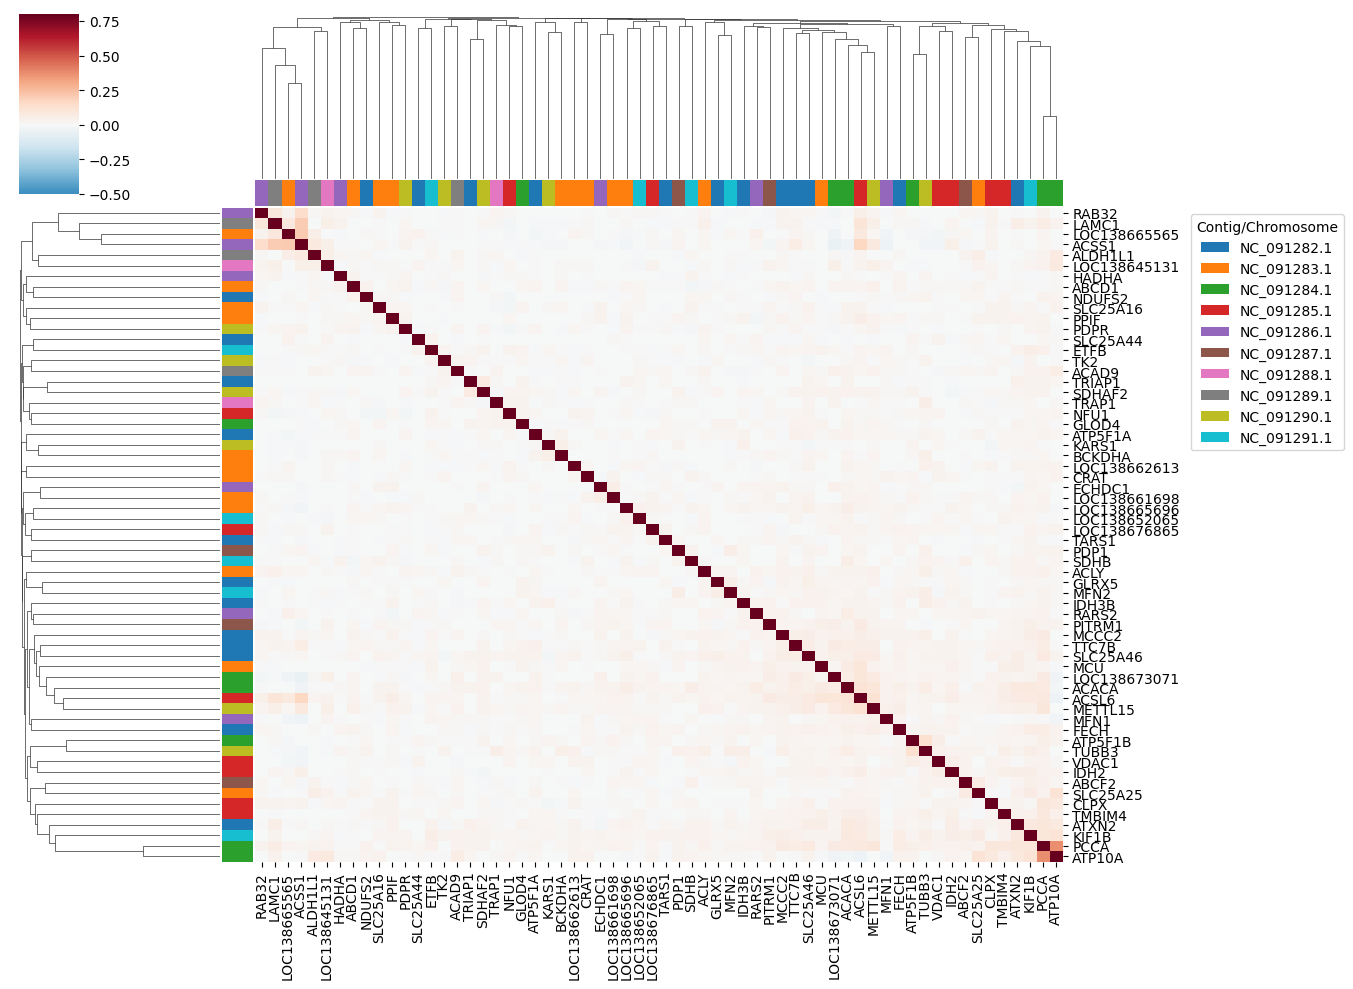

In [ ]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

adata = sc.read_h5ad('/home/gyang/HDD/0.Software_annos/BCP_utilities/resource/sample1_filtered_QC2.h5ad')
cand = pd.read_csv('RI_mito_candidate.tsv', sep='\t')
genes = cand['X'].tolist()
genes_present = [g for g in genes if g in adata.var_names]

adata_mt = adata[:, genes_present]
expr = adata_mt.X.toarray() if hasattr(adata_mt.X, 'toarray') else adata_mt.X
corr = np.corrcoef(expr.T)


gene_to_contig = dict(zip(result['gene_id'], result['seqname']))

contigs = [gene_to_contig.get(g, 'Unknown') for g in genes_present]
unique_contigs = sorted(set(contigs))
colors = sns.color_palette('tab10', n_colors=len(unique_contigs))
contig_colors = {contig: colors[i] for i, contig in enumerate(unique_contigs)}


row_colors = [contig_colors[contig] for contig in contigs]

cg = sns.clustermap(
    corr, 
    cmap='RdBu_r',  
    center=0,     
    vmin=-0.5,     
    vmax=0.8,      
    xticklabels=genes_present, 
    yticklabels=genes_present,
    row_colors=row_colors,
    col_colors=row_colors,
    figsize=(12, 10),
    method='average',
    metric='correlation'
)

legend_elements = [mpatches.Patch(facecolor=contig_colors[contig], label=contig) 
                  for contig in unique_contigs]
cg.ax_heatmap.legend(handles=legend_elements, title='Contig/Chromosome', 
                    bbox_to_anchor=(1.15, 1), loc='upper left')

plt.show()


In [31]:
adata.var_names

Index(['LOC138657619', 'LOC138657594', 'LOC138657660', 'LOC138657677',
       'LOC138657667', 'LOC138657686', 'LOC138657722', 'LOC138657560',
       'LOC138657726', 'TMEM8B',
       ...
       'LOC138656345', 'LOC138656347', 'LOC138656547', 'LOC138656545',
       'LOC138656549', 'LOC138656617', 'LOC138656616', 'LOC138656628',
       'LOC138656654', 'LOC138656655'],
      dtype='object', length=21243)